In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2026-02-16 08:28:57.743268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771230537.926728      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771230537.984526      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771230538.450871      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771230538.450910      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771230538.450913      55 computation_placer.cc:177] computation placer alr

In [2]:
# Configure GPU Memory Growth (prevents OOM errors)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# 1. Load Data
df = pd.read_csv('/kaggle/input/test-2/clean_smart_meter_data.csv')

# 2. Time Conversion & Sorting
df['FULL_TIME'] = pd.to_datetime(df['FULL_TIME'], errors='coerce')
df = df.sort_values('FULL_TIME').reset_index(drop=True).dropna(subset=['FULL_TIME'])

# DIAGNOSTIC: Confirm data range
print("--- Input Data Status ---")
print(f"Voltage Range: {df['VLL'].min():.2f} to {df['VLL'].max():.2f}")
print("Data loaded successfully.")

--- Input Data Status ---
Voltage Range: -8.49 to 18.95
Data loaded successfully.


In [4]:
df.head(10)

,FULL_TIME,NODEID,V1,V2,V3,VLL,I1,I2,I3,ILL,...,INN,log_PTOTAL,log_QTOTAL,log_STOTAL,P_per_I,P_per_V,Load_Index,hour,day,month
0,2018-04-25 14:09:00,6.0,232.252,225.023,222.273,-1.025452,0.008338,1.663520,5.387790,0.663324,...,4.77222,0.884395,0.512835,0.945391,0.148586,0.742688,-0.362897,14,25,4
1,2018-04-25 14:10:00,2.0,220.971,222.321,212.061,-1.726707,0.007084,0.007540,1.566560,-0.150502,...,1.55925,0.258389,0.147692,0.289268,-0.171713,-0.099548,-0.371468,14,25,4
2,2018-04-25 14:10:00,1.0,243.071,241.760,224.628,-0.158534,0.662968,0.337969,0.594877,-0.148329,...,0.29687,0.316986,0.046393,0.319530,0.844865,-0.060651,-0.370697,14,25,4
3,2018-04-25 14:10:00,3.0,215.214,226.386,232.943,-1.170532,22.752800,9.705070,0.036927,4.441708,...,19.74500,2.035356,1.242785,2.092164,0.222658,4.730345,-0.315095,14,25,4
4,2018-04-25 14:10:00,4.0,228.357,236.243,229.014,-0.617771,19.856700,13.585400,6.311660,5.520046,...,11.74110,2.266961,1.288577,2.321342,0.497752,6.066590,-0.293762,14,25,4
5,2018-04-25 14:10:00,7.0,231.540,233.040,220.660,-0.860492,0.000000,0.000000,2.952380,0.053188,...,2.95238,0.391604,0.365459,0.501666,-0.690302,0.028504,-0.369159,14,25,4
6,2018-04-25 14:10:00,8.0,231.592,233.005,221.787,-0.827309,55.827200,62.032000,82.920700,26.860954,...,24.58550,3.825992,2.241515,3.845321,1.080539,33.207849,0.080777,14,25,4
7,2018-04-25 14:14:00,2.0,220.971,222.321,212.061,-1.726707,0.009146,0.013990,2.080860,-0.072839,...,2.06929,0.337519,0.176236,0.369078,-0.078295,-0.016094,-0.369528,14,25,4
8,2018-04-25 14:15:00,3.0,215.214,224.729,229.986,-1.304267,23.014800,9.623260,0.032174,4.467779,...,19.99400,2.042363,1.217716,2.094716,0.234429,4.806408,-0.265788,14,25,4
9,2018-04-25 14:15:00,6.0,228.889,222.242,218.654,-1.308434,0.011137,1.655240,5.296150,0.648894,...,4.68458,0.864639,0.510687,0.927603,0.062663,0.722051,-0.353464,14,25,4


In [5]:
# 1. Create Temporal Features (Before scaling)
df['Hour'] = df['FULL_TIME'].dt.hour
df['DayOfWeek'] = df['FULL_TIME'].dt.dayofweek
# Cyclical Encoding (Best for AI)
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# 2. Safety Scaling (Crucial Fix)
# Your data has negatives. We shift everything to [0, 1] range.
# This prevents math errors and helps the LSTM converge.
cols_to_scale = ['PTOTAL', 'QTOTAL', 'STOTAL', 'ILL', 'VLL', 'PFAVG', 'FREQ', 'Hour_Sin', 'Hour_Cos']

# Handle NaNs if any exist
df[cols_to_scale] = df[cols_to_scale].fillna(0)

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Save scaler for Dashboard
joblib.dump(scaler, 'safe_scaler.pkl')
print("Data re-scaled to [0, 1] range. Ready for AI.")

Data re-scaled to [0, 1] range. Ready for AI.


In [6]:
# 1. Fundamental Limits (Voltage, Frequency, Non-Negativity)
mask_physics = (
    (df['VLL'] > 100) & (df['VLL'] < 500) &   # Voltage must be realistic (e.g., 230V system)
    (df['ILL'] >= 0) &                        # Current cannot be negative
    (df['PTOTAL'] >= 0) &                     # Active power cannot be negative (unless solar backfeed)
    (df['FREQ'].between(45, 55))              # Grid Frequency must be stable (~50Hz)
)
df_clean = df[mask_physics].copy()

# 2. Power Triangle Consistency Check (S = sqrt(P^2 + Q^2))
# We filter out rows where the meter's calculation deviates > 15% from physics
S_theoretical = np.sqrt(df_clean['PTOTAL']**2 + df_clean['QTOTAL']**2)
deviation = np.abs(df_clean['STOTAL'] - S_theoretical) / (df_clean['STOTAL'] + 1e-6)

df_clean = df_clean[deviation < 0.15].copy()

print(f"Cleaned Shape: {df_clean.shape} (Rows Dropped: {len(df) - len(df_clean)})")

Cleaned Shape: (0, 44) (Rows Dropped: 756445)


In [7]:
SEQ_LEN = 60  # Lookback Window (60 steps)

def create_sequences(data, seq_len, feature_col):
    data_val = data[feature_col].values
    xs = []
    for i in range(len(data) - seq_len):
        xs.append(data_val[i:(i + seq_len)])
    return np.array(xs)

# Train on the main pattern: PTOTAL
X_seq = create_sequences(df_scaled, SEQ_LEN, 'PTOTAL')
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

print(f"LSTM Input Shape: {X_seq.shape}")

LSTM Input Shape: (756385, 60, 1)


In [8]:
LATENT_DIM = 32

inputs = Input(shape=(SEQ_LEN, 1))

# Encoder: Bidirectional (Past + Future Context)
# This is "Advanced" because standard LSTMs only look backwards.
encoded = Bidirectional(LSTM(128, return_sequences=True))(inputs)
encoded = Dropout(0.3)(encoded)
encoded = Bidirectional(LSTM(64, return_sequences=False))(encoded)
latent_vec = Dense(LATENT_DIM, activation='tanh', name='bottleneck')(encoded)

# Decoder: Reconstruction
decoded = RepeatVector(SEQ_LEN)(latent_vec)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
output = TimeDistributed(Dense(1))(decoded)
# Compile
model_ae = Model(inputs, output)
model_ae.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model_ae.fit(
    X_seq, X_seq,
    epochs=20,  
    batch_size=512,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)
model_ae.save('advanced_lstm.h5')

I0000 00:00:1771230559.629175      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1771230569.217933     123 cuda_dnn.cc:529] Loaded cuDNN version 91002


1256/1256 ━━━━━━━━━━━━━━━━━━━━ 98s 71ms/step - loss: 0.0167 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 2/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0164 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 3/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0161 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 4/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0152 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 5/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0144 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 6/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0139 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 7/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0134 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 8/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0129 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 9/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - loss: 0.0126 - val_loss: 0.0096 - learnin

In [9]:
# 1. Extract Deep Embeddings (The "Brain" of the LSTM)
encoder_only = Model(inputs=model_ae.input, outputs=model_ae.get_layer('bottleneck').output)
embeddings = encoder_only.predict(X_seq, batch_size=1024)
df_emb = pd.DataFrame(embeddings, columns=[f'Emb_{i}' for i in range(LATENT_DIM)])

# 2. Align Data
# Trim first SEQ_LEN rows (history gap)
df_trim = df_scaled.iloc[SEQ_LEN:].reset_index(drop=True)

# Select Explicit Features
explicit_feats = ['VLL', 'ILL', 'PFAVG', 'FREQ', 'Hour_Sin', 'Hour_Cos']

# 3. Fuse (Deep Features + Physics Features)
X_hybrid = pd.concat([df_emb, df_trim[explicit_feats]], axis=1)
y_target = df_trim['PTOTAL']

print(f"Hybrid Input Shape: {X_hybrid.shape}")

739/739 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step
Hybrid Input Shape: (756385, 38)


Training on 605108 samples, Testing on 151277 samples...
[0]	validation_0-rmse:0.05807	validation_1-rmse:0.04386
[100]	validation_0-rmse:0.01506	validation_1-rmse:0.01580
[200]	validation_0-rmse:0.00733	validation_1-rmse:0.01198
[300]	validation_0-rmse:0.00536	validation_1-rmse:0.01154
[400]	validation_0-rmse:0.00424	validation_1-rmse:0.01137
[500]	validation_0-rmse:0.00356	validation_1-rmse:0.01129
[600]	validation_0-rmse:0.00314	validation_1-rmse:0.01126
[700]	validation_0-rmse:0.00285	validation_1-rmse:0.01125
[800]	validation_0-rmse:0.00264	validation_1-rmse:0.01124
[900]	validation_0-rmse:0.00244	validation_1-rmse:0.01123
[999]	validation_0-rmse:0.00229	validation_1-rmse:0.01123
------------------------------
🎯 FINAL MODEL PERFORMANCE
------------------------------
✅ Accuracy (R2 Score) : 0.9359  (Target: > 0.90)
📉 Error (RMSE)        : 0.0112  (Target: < 0.10)
------------------------------


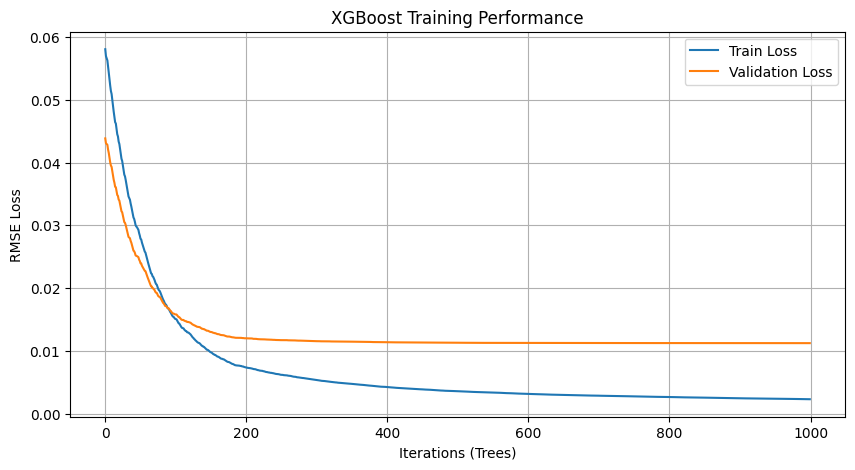

Model Saved.


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Prepare Data (Time-Series Split)
split = int(len(X_hybrid) * 0.8)
X_train, X_test = X_hybrid.iloc[:split], X_hybrid.iloc[split:]
y_train, y_test = y_target.iloc[:split], y_target.iloc[split:]

print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples...")

# 2. Configure XGBoost (Fixed 'early_stopping_rounds' location)
regressor = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,     # Slower learning = Better generalization
    max_depth=8,            # Capture complex interactions
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,          # L1 Regularization
    reg_lambda=0.1,         # L2 Regularization
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50 # <--- Fixed: Inside constructor
)

# 3. Train
# We capture the evaluation result in 'evals_result' to plot the loss later
regressor.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# 4. Evaluation & Metrics
preds = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("-" * 30)
print("🎯 FINAL MODEL PERFORMANCE")
print("-" * 30)
print(f"✅ Accuracy (R2 Score) : {r2:.4f}  (Target: > 0.90)")
print(f"📉 Error (RMSE)        : {rmse:.4f}  (Target: < 0.10)")
print("-" * 30)

# 5. Plot Loss Curve
results = regressor.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation Loss')
plt.legend()
plt.ylabel('RMSE Loss')
plt.xlabel('Iterations (Trees)')
plt.title('XGBoost Training Performance')
plt.grid(True)
plt.show()

# 6. Save
joblib.dump(regressor, 'advanced_xgb.pkl')
print("Model Saved.")

In [11]:
# ================================
# ANOMALY DETECTION PHASE
# Residual-Based Rolling Method
# ================================

import numpy as np
import pandas as pd

# ---- 1️⃣ Compute Residuals ----
residuals = np.abs(y_test.values - preds)


# ---- 2️⃣ Proper Timestamp Alignment ----
sequence_length = 60  # same value used in your LSTM

# Remove initial sequence offset
aligned_timestamps = df['FULL_TIME'].iloc[sequence_length:].reset_index(drop=True)

# Apply same 80/20 split used in training
split_index = int(len(aligned_timestamps) * 0.8)

test_timestamps = aligned_timestamps.iloc[split_index:].reset_index(drop=True)


# ---- 3️⃣ Safety Check (Important) ----
print("Timestamp Length:", len(test_timestamps))
print("y_test Length:", len(y_test))
print("Predictions Length:", len(preds))


# ---- 4️⃣ Create Anomaly DataFrame ----
anomaly_df = pd.DataFrame({
    "Timestamp": test_timestamps,
    "Actual_Energy": y_test.values,
    "Predicted_Energy": preds,
    "Residual": residuals
})


# ---- 5️⃣ Rolling Adaptive Threshold ----
window_size = 24   # For hourly data (change if needed)

anomaly_df["Rolling_Mean"] = anomaly_df["Residual"].rolling(window=window_size).mean()
anomaly_df["Rolling_STD"] = anomaly_df["Residual"].rolling(window=window_size).std()

anomaly_df["Threshold"] = anomaly_df["Rolling_Mean"] + 2 * anomaly_df["Rolling_STD"]


# ---- 6️⃣ Detect Anomalies ----
anomaly_df["Anomaly"] = anomaly_df["Residual"] > anomaly_df["Threshold"]
anomaly_df["Anomaly"] = anomaly_df["Anomaly"].fillna(False)


# ---- 7️⃣ Deviation Percentage (XAI Ready) ----
anomaly_df["Deviation_%"] = (
    anomaly_df["Residual"] / anomaly_df["Actual_Energy"]
) * 100


# ---- 8️⃣ Summary ----
total_anomalies = anomaly_df["Anomaly"].sum()
percentage = (total_anomalies / len(anomaly_df)) * 100

print("Total Anomalies Detected:", total_anomalies)
print("Anomaly Percentage:", round(percentage, 2), "%")

anomaly_df.head()


Timestamp Length: 151277
y_test Length: 151277
Predictions Length: 151277
Total Anomalies Detected: 8281
Anomaly Percentage: 5.47 %


,Timestamp,Actual_Energy,Predicted_Energy,Residual,Rolling_Mean,Rolling_STD,Threshold,Anomaly,Deviation_%
0,2020-01-03 11:36:00,0.010721,0.011577,0.000856,NaN,NaN,NaN,False,7.982553
1,2020-01-03 11:36:00,0.168990,0.181374,0.012384,NaN,NaN,NaN,False,7.328422
2,2020-01-03 11:36:00,0.003825,0.003683,0.000142,NaN,NaN,NaN,False,3.722073
3,2020-01-03 11:36:00,0.009074,0.009457,0.000383,NaN,NaN,NaN,False,4.217058
4,2020-01-03 11:36:00,0.040811,0.039692,0.001120,NaN,NaN,NaN,False,2.743689


In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 0.011228445345752843
R2 Score: 0.9358717881317202
